# Giriş

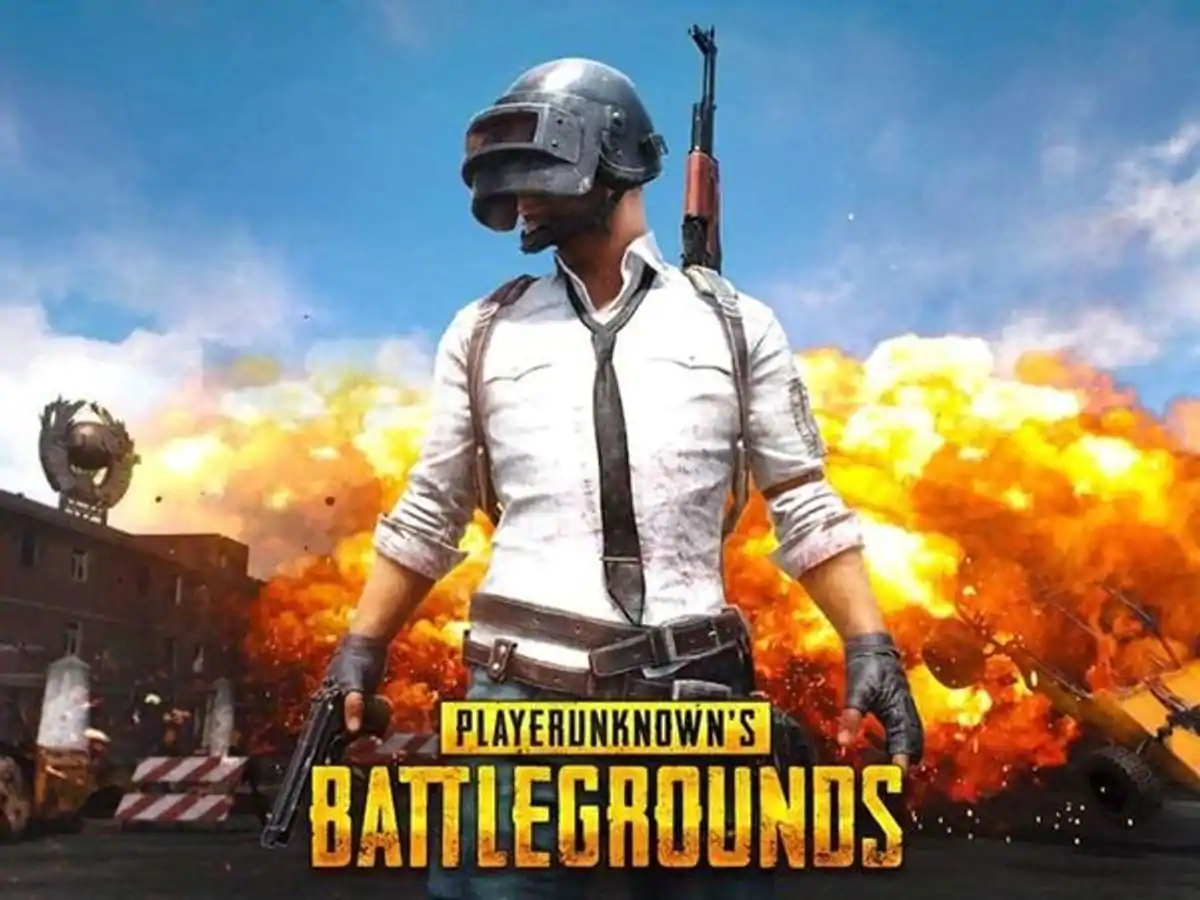

Pubg, günümüzde popüler olan online savaş oyunlarından biridir. Bu oyun akıllı telefon, bilgisayar vb. ortamlar üzerinden oynanabilmektedir. 
Oyun içerisinde çeşitli oyun türleri barındırmaktadır. Oyundaki temel oyun türünde online olarak en fazla 100 kişinin olduğu haritalarda en iyi savaş stratejilerini uygularak birinci olmak amaçtır. 
Oyun içerisinde binalardan toplanan çeşitli silahlar, sağlık malzemeleri, silah eklentileri, bombalar alınır. Bu datasette savaş malzemelerinden biri olan silahları incelenmektedir.

<font color="blue">
İçerik

1. [Veri Yükleme ve İnceleme](#1)
2. [Özelliklerin İncelenmesi](#2)
3. [Eksik Veri](#3)
4. [Aykırı Değer Tespiti](#4)
5. [Basit Veri Analizi ve Görsel İncelenmesi](#5)

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import math 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import warnings
warnings.filterwarnings("ignore")

from collections import Counter

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

<a id=1></a>
## Veri Yükleme ve İnceleme

Oyun içi silahlarla ilgili sunulan veri setinin dosya türü csv dosyadır.

In [ ]:
df = pd.read_csv("/kaggle/input/pubg-weapon-stats/pubg-weapon-stats.csv")

* Veri seti genel bakış ile neler olduğuna bakmak için popülasyon içerisinden örneklem çekilmesi

In [ ]:
df.head()

<a id=2></a>
## Özelliklerin Tanımlanması

* Weapon Name : Silah adı
* Weapon Type : Silahın türü
* Bullet Type : Silahın mermi türü
* Damage      : Silahın verdiği hasar
* Magazine Capacity : Silahın kapasitesi
* Range : Metre cinsinden silahın menzili
* Bullet Speed : Mermi hızı
* Rate of Fire : Silah atış hızı
* Shot to Kill(Chest) : Bir oyuncuyu öldürmek için gereken vücuduna yapılması gereken atış sayısı 
* Shot to Kill(Head) : Bir oyuncuyu öldürmek için gereken başına yapılması gereken atış sayısı 

In [ ]:
df.info()

* Veri setinde 44 gözlem birimi vardır.
* Veri setinde verilen özellikleri 17 tanesi sayısal değerken , 3 tane kategorik değişken bulunmaktadır.
* Bullet Type , Range , Bullet Speed , BDMG_(0,1,2,3) , HDMG_(0,1,2,3) değerlerinde eksik veriler vardır.

* Özellik adlarındaki düzensiz formatı düzenlemek gerekir.

In [ ]:
kolon = []
for i in df.columns:
   i = i.replace(" ", "_")
   kolon.append(i.replace("(","").strip(")"))
                
df.columns = kolon
df.columns

* Object türündeki kategorik değişkenleri "category" veri türüne çekmek bazen hatalarla karşılaşılmasının önlemi olur.

In [ ]:
kategorik_degisken = df.select_dtypes(include=["object"]).columns
for i in kategorik_degisken:
    df[i] = pd.Categorical(df[i])
df.dtypes

* Veri setinde sunulan özelliklerin isimleri

In [ ]:
df.columns

* Veri setinde yer alan silahların isimleri

In [ ]:
silah_isimleri = pd.DataFrame(df.Weapon_Name.unique(), columns=["Silah_İsimleri"])
silah_isimleri

* Veri setindeki silahların türlerine göre saniyedeki hasar ve öldürmek için gereken atış sayısının 

In [ ]:
df.pivot_table( ["Bullet_Type","Damage", "Damage_Per_Second","Shots_to_Kill_Head","Shots_to_Kill_Chest"] , index = ["Weapon_Type" , "Weapon_Name"])

* Bu pivot tabloya bakılarak baş hedef almakta sorun yaşıyan baş yerine vücuda atış yapan oyuncuların shotgun yani pompalı silahlarla oynaması başarı getirebilir.

* İsabet sıkıntısı yaşıyan oyunculara için damage değeri düşük olan fakat büyük olasılıkla atış hızı yüksek olduğundan saniyedeki hasar yani damage per second değeri yüksek değerli olan silahlar önerilebilir. Damage per second özelliği 100 üzeri olanlar işe yaracaktır.

* Hedef almakta iyi olan oyuncular için sniper rifle çok uygun olacaktır.

* Verilen özelliklerden sayısal özelliklerin betimsel bazı istatistiksel değerler

In [ ]:
df.describe().T

* Range , Bullet Speed özellikleri geniş bir yayılımı olduğu yani basık bir yapıda olduğunu düşündürüyor.

* Damage Per Second özelliği silahları ayırt etmekte önemli bir metrik olabilir.

<a id = 3></a>
## Eksik Veri

* Eksik verilerin olduğu özellikler

In [ ]:
df.columns[df.isnull().any()]

* Eksik veri olan kolonlarda toplam eksik gözlem sayısı

In [ ]:
df.isnull().sum()

* Veri seti hikayesinden biliniyor ki "Bullet Type" özelliği sayısal olarak girilse de kategorik değişkendir.Bunun hikaye ve değerlerden yola çıkarak incelenmesi gerekmektedir.

* Range ,Bullet özelliklerin doldurulmasında medyan ya da ortalama alınabilir. Bunun ile ilgili inceleme yapmak gerekir.

* BDMG ve HDMG özelliklerini ise inceleme yapılacak özellikler olmadığından 0 değeri ile doldurulabilir.

* BDMG ve HDMG özelliğini doldurma

In [ ]:
for i in df.columns:
    if ("BDMG" in i) | ("HDMG" in i):
        df[i].fillna(0, inplace=True)
df.isnull().sum()

* Range özelliğini doldurmak adına incelemek

In [ ]:
df.Range.mean()

In [ ]:
df.Range.median()

* Range özelliği için ortalama ve median yakın olduğundan her ikisi de kullanılabilir. Ortalama değeri tercih edelim.

In [ ]:
df.Range.fillna(df.Range.mean(), inplace=True)
df.isnull().sum()

* Bullet_Speed özelliği için aynı inceleme yapılır.

In [ ]:
df.Bullet_Speed.mean()

In [ ]:
df.Bullet_Speed.median()

* Buradaki fark silah türleri ile ilişkili olabilir. O yüzden gruplama yapıp aynı incelemeyi yapmak mantıklı olabilir.

In [ ]:
df.groupby("Weapon_Type").aggregate({"Bullet_Speed": [np.mean, np.median]})

* Gruplandığı zaman ortalama ve medyan değerlerinin daha yakınlaştığını gözlemlenebilir. Fakat bazı silahlarda fark azken bazılarında fazla olduğundan silah türüne göre mermi hızının medyanı ile doldurmak daha iyi olacaktır.

In [ ]:
gruplanan_hiz_sozlugu =dict(df.groupby("Weapon_Type")["Bullet_Speed"].median())
for x,y in gruplanan_hiz_sozlugu.items():
    if math.isnan(float(y)) :
        gruplanan_hiz_sozlugu[x] = 0.0
        
df_bullet = df[df["Bullet_Speed"].isnull().values]
indeks = df_bullet.index.tolist()
deger = []

for i in df_bullet["Weapon_Type"] :
    deger.append(gruplanan_hiz_sozlugu[i])

df_bullet.drop("Bullet_Speed" , axis=1)
df_bullet["Bullet_Speed"] = deger
df[df["Bullet_Speed"].isnull().values] = df_bullet

df.isnull().sum()

* Bullet Type özelliği eksik veri incelemesi

In [ ]:
df["Bullet_Type"].unique()

Burada eksik olan değerler boş bırakılmamış yakın dövüş silahlarının mermisi olmadığından mermi türü belirtilmeyip nan bırakılmış. Bu verilerin böyle bırakılması daha doğru olacaktır.Çünkü sınırlı veriye sahip veri setinde tek özellik için gözlem silmek mantıklı değil hatta bilinçli olarak yani o silahların bu özelliği olmadığından boş bırakılmasına rağmen işlem yapılması doğru olmayacaktır.

<a id=4></a>
## Aykırı Değer Tespiti

* Bu veri setinde gözlem birimi çok olmadığından aykırı gözlemlerle denk gelindiğinde silmek yerine baskılama yöntemi kullanılmalıdır.
* Aykırı gözlem incelemesi yapılması gereken özellikler; Damage, Damage_Per_Second, Magazine_Capacity, Range, Bullet_Speed, Rate_of_Fire.
* Aykırı gözlemleri görmek adına boxplot iyi bir araçtır.

In [ ]:
def box_plot(df , f1, f2):
        sns.boxplot(x=f1 , y=f2 , data = df)
        plt.show();

In [ ]:
x_ekseni = ["Damage","Damage_Per_Second", "Magazine_Capacity", "Range", "Bullet_Speed", "Rate_of_Fire"]
y_ekseni = "Weapon_Type"
for i in x_ekseni:
    box_plot(df,i,y_ekseni)

* Silah türlerine göre çeşitli aykırılıklar söz konusu fakat bunların üzerine herhangi bir işlem (silmek ya da baskılama gibi) uygulanmayacaktır.

<a id=5></a>
## Basit Veri Analizi ve Görsel İncelenmesi

#### Weapon Type Özelliğindeki Frekansın İncelenmesi

In [ ]:
sns.set()
plt.figure(figsize=(25,10))
sns.countplot(df["Weapon_Type"])
plt.show()

#### Shots_To_Kill_(Head/Chest) ve Weapon_Type İncelemesi

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(25,10))
sns.barplot(ax=axes[0], x="Weapon_Type", y="Shots_to_Kill_Head" ,data=df)
sns.barplot(ax=axes[1], x="Weapon_Type", y="Shots_to_Kill_Chest" , data=df);

#### Bullet_Type ve Damage İlişki İnceleme

In [ ]:
df[["Bullet_Type" , "Damage"]].groupby(["Bullet_Type"] , as_index=False).mean()

In [ ]:
(sns.FacetGrid(df,
              hue="Bullet_Type",
              height=5,
              xlim = (0,300))
   .map(sns.kdeplot, "Damage" , shade=True)
   .add_legend()
);

* Mermi türlerinden 5.56 olan silahların diğer özellikleri açısından farklılık olsa da sivri bir grafik var yani hasar verme oranları genellikle aynı denilebilir.

* Diğer mermi türlerinde çift tepelilik ve çarpıklık olduğundan başka özelliklerin hasar oranlarına etkisi var denilebilir.

####  Weapon Type ve Range of Fire İncelenmesi

In [ ]:
sns.barplot(y="Weapon_Type" , x = "Range" , data=df)

* Uzaktaki bir düşman oyuncuyu vurmak isterseniz rifle yani keskin nişancıları tercih etmek gerekir. Pistol, shotgun, other, melee türleri ile bu isteği gerçekleştirmek mümkün değil.

#### Damage Özelliğinde En İyi 10 Silah

In [ ]:
df[["Weapon_Name" , "Damage"]].sort_values(by = "Damage" , ascending = False)[:10].reset_index(drop=True)

#### Range Özelliğinde En İyi 5 Silah

In [ ]:
df[["Weapon_Name" , "Range"]].sort_values(by = "Range" , ascending = False)[:5].reset_index(drop=True)

#### Weapon_Type Özelliğine Göre Ortalama Range

In [ ]:
wt_range=df[["Weapon_Type" , "Range"]].groupby(["Weapon_Type"],as_index=False).mean().sort_values(by="Range").reset_index(drop=True)
wt_range

In [ ]:
sns.pairplot(data=df.select_dtypes(["float64" , "int64"]) , vars = ["Range","Damage","Damage_Per_Second","Magazine_Capacity"]);